In [1]:
%config InlineBackend.figure_format = 'retina'

from utils.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import time
import progressbar
import warnings

sns.set()
warnings.filterwarnings('ignore')

In [ ]:
ts = get_flow_series_by_idx(6)
ts = ts.resample('15min').sum()
test_size = 4*24*7
train_ts = ts.iloc[0:-test_size]
test_ts = ts.iloc[-test_size:]

# $\hat{y}(t)=y(t-1)$

In [2]:
pd.DataFrame(calc_metrics(ts.iloc[-4*24*7:], ts.iloc[-4*24*7-1:-1]), index=[0])

,mae,rmse,mape
0,10.739583,16.250778,26.692537


# MA

In [3]:
df = pd.DataFrame(columns=['mae','rmse','mape'])
df.index.name = 'span'
for i in range(1,8):
    rts = ts.shift(1).rolling(i).mean().iloc[-4*24*7:]
    df.loc[i] = calc_metrics(ts.iloc[-4*24*7:], rts.iloc[-4*24*7:])
df

,mae,rmse,mape
span,,,
1,10.739583,16.250778,26.692537
2,11.169643,17.169585,27.050295
3,12.233135,18.801147,28.506456
4,13.575521,20.736632,31.179540
5,15.060714,22.671019,35.016777
6,16.555804,24.619676,39.341313
7,17.902849,26.312128,43.553651


# EMA

In [4]:
df = pd.DataFrame(columns=['mae','rmse','mape'])
df.index.name = 'span'
for i in range(1,8):
    rts = ts.shift(1).ewm(span=i).mean().iloc[-4*24*7:]
    df.loc[i] = calc_metrics(ts.iloc[-4*24*7:], rts.iloc[-4*24*7:])
df

,mae,rmse,mape
span,,,
1,10.739583,16.250778,26.692537
2,10.900601,16.578472,26.267867
3,11.815691,17.867713,28.364314
4,12.920859,19.309500,31.344698
5,14.110492,20.737723,34.942684
6,15.408925,22.114551,39.158159
7,16.699194,23.433801,43.797514


# ARIMA without stl

In [5]:
from statsmodels.tsa.stattools import adfuller as ADF
def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries.tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1.tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2.tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)


diff(train_ts)  # ADF检验证明不需要差分

timeseries_adf :  (-9.52021225649231, 3.07925783251382e-16, 27, 2180, {'1%': -3.4333532186762805, '5%': -2.862866720471125, '10%': -2.5674762791431696}, 18377.61913985323)
timeseries_diff1_adf :  (-12.151704168681935, 1.564904434069737e-22, 18, 2189, {'1%': -3.4333408565184294, '5%': -2.8628612620249507, '10%': -2.5674733728800154}, 18454.934355054604)
timeseries_diff2_adf :  (-15.888866963334156, 8.586717819487594e-29, 27, 2180, {'1%': -3.4333532186762805, '5%': -2.862866720471125, '10%': -2.5674762791431696}, 18543.02963171594)


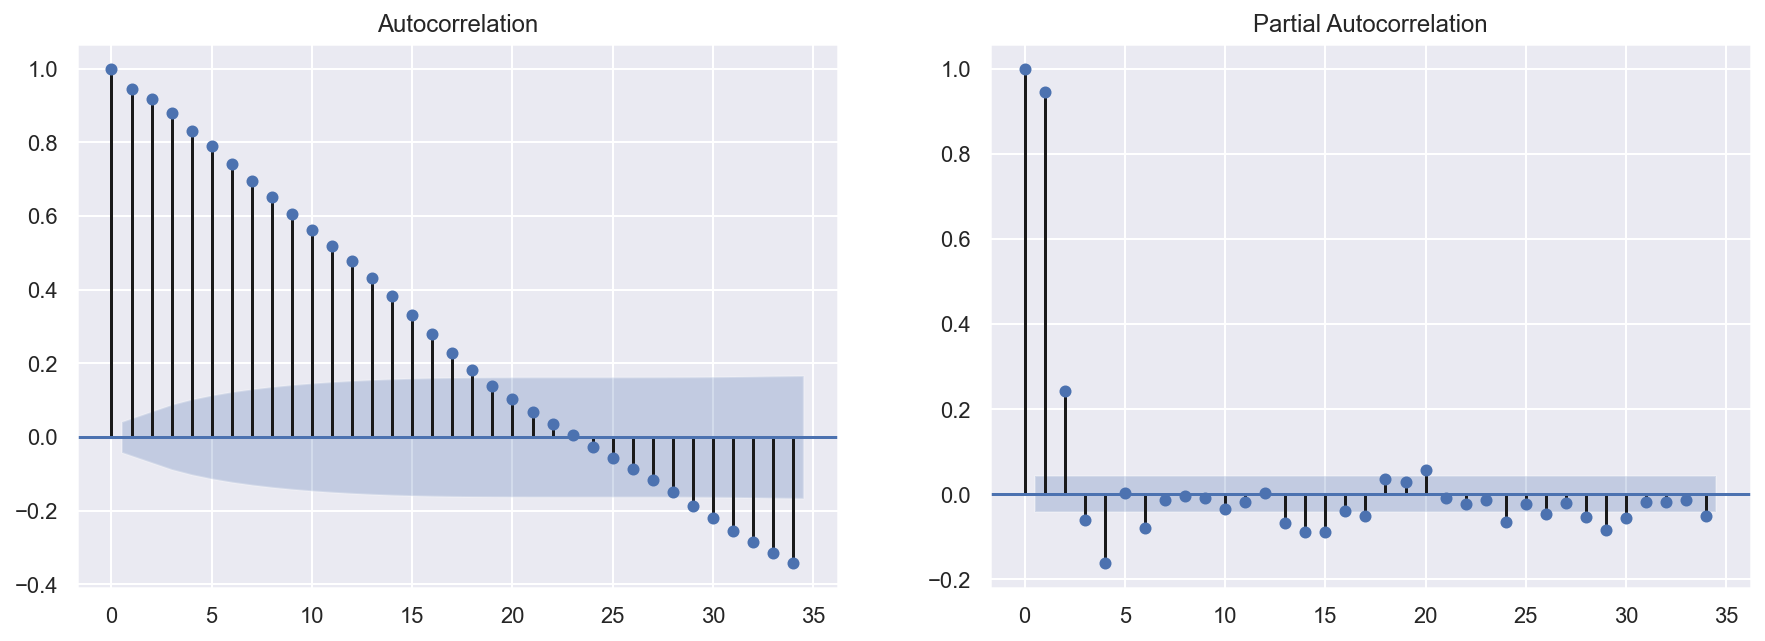

In [6]:
# org
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(train_ts, ax=plt.gca())
plt.subplot(122)
plot_pacf(train_ts, ax=plt.gca())
plt.show()  # ACF没有迅速截尾

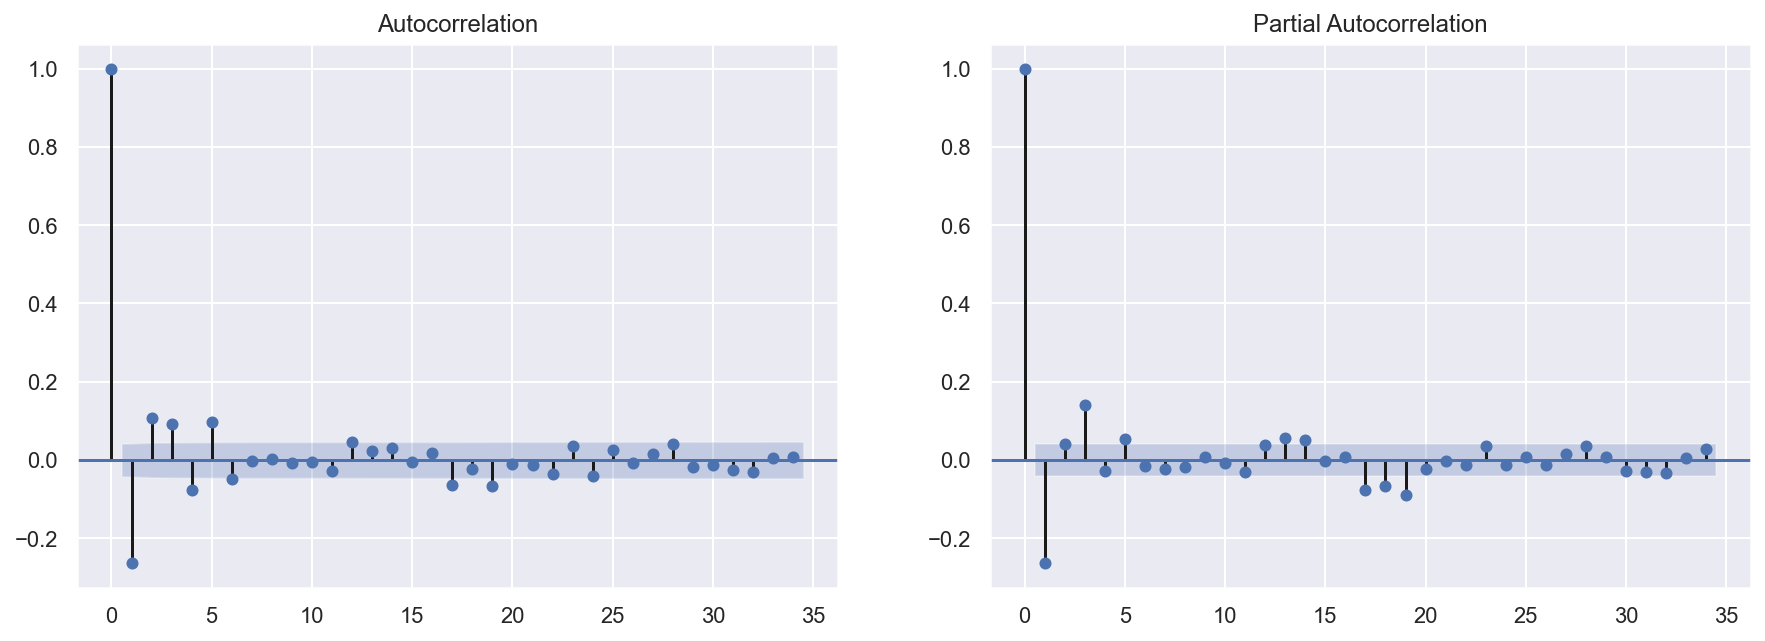

In [7]:
# diff 1
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(train_ts.diff(1).dropna(), ax=plt.gca())
plt.subplot(122)
plot_pacf(train_ts.diff(1).dropna(), ax=plt.gca())
plt.show()  # ACF与PACF都很快截尾

## org

In [8]:
# 自动化调参
model = auto_arima(train_ts, trace=True)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=18665.638, BIC=18699.837, Time=1.056 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=23772.831, BIC=23784.231, Time=0.029 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=18846.943, BIC=18864.043, Time=0.131 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=21796.278, BIC=21813.378, Time=0.418 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=25915.235, BIC=25920.935, Time=0.017 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=18679.535, BIC=18708.035, Time=0.847 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=18714.462, BIC=18742.961, Time=0.661 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=18610.546, BIC=18650.445, Time=2.529 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=18607.176, BIC=18641.375, Time=2.320 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1

In [9]:
model

ARIMA(maxiter=50, method='lbfgs', order=(4, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [10]:
history_lst = train_ts.tolist()
test_lst = test_ts.tolist()
y_pred = []

order = (4,0,3)
model = ARIMA(history_lst, order=order).fit()
y_pred.append(model.forecast()[0][0])

p = progressbar.ProgressBar()
for i in p(range(test_size-1)):
    history_lst.append(test_lst[i])
    model = ARIMA(history_lst, order=order).fit()
    y_pred.append(model.forecast()[0][0])

y_true = np.array(test_lst)
y_pred = np.array(y_pred)

100% (671 of 671) |######################| Elapsed Time: 0:20:59 Time:  0:20:59


(500.0, 600.0)

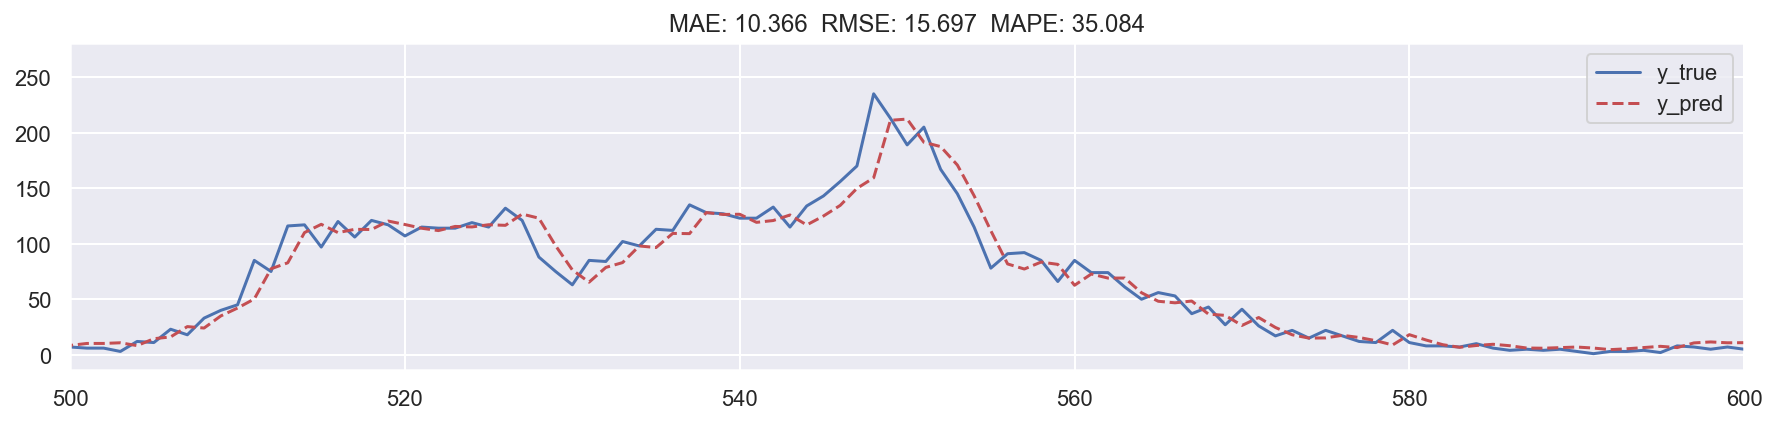

In [11]:
%matplotlib inline
test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))
plt.xlim([500,600])  # 存在严重的平移现象

In [12]:
pd.DataFrame(calc_metrics(y_true, y_pred), index=[0])

,mae,rmse,mape
0,10.365826,15.696627,35.084463


## diff

为了解决平移问题，采取差分的方法

In [13]:
history_lst = train_ts.tolist()
test_lst = test_ts.tolist()
y_pred = []

order = auto_arima(train_ts, d=1).order
print('order:', order)

model = ARIMA(history_lst, order=order).fit()
y_pred.append(model.forecast()[0][0])

p = progressbar.ProgressBar()
for i in p(range(test_size-1)):
    history_lst.append(test_lst[i])
    model = ARIMA(history_lst, order=order).fit()
    y_pred.append(model.forecast()[0][0])

y_true = np.array(test_lst)
y_pred = np.array(y_pred)

order: (3, 1, 2)


100% (671 of 671) |######################| Elapsed Time: 0:08:35 Time:  0:08:35


(500.0, 600.0)

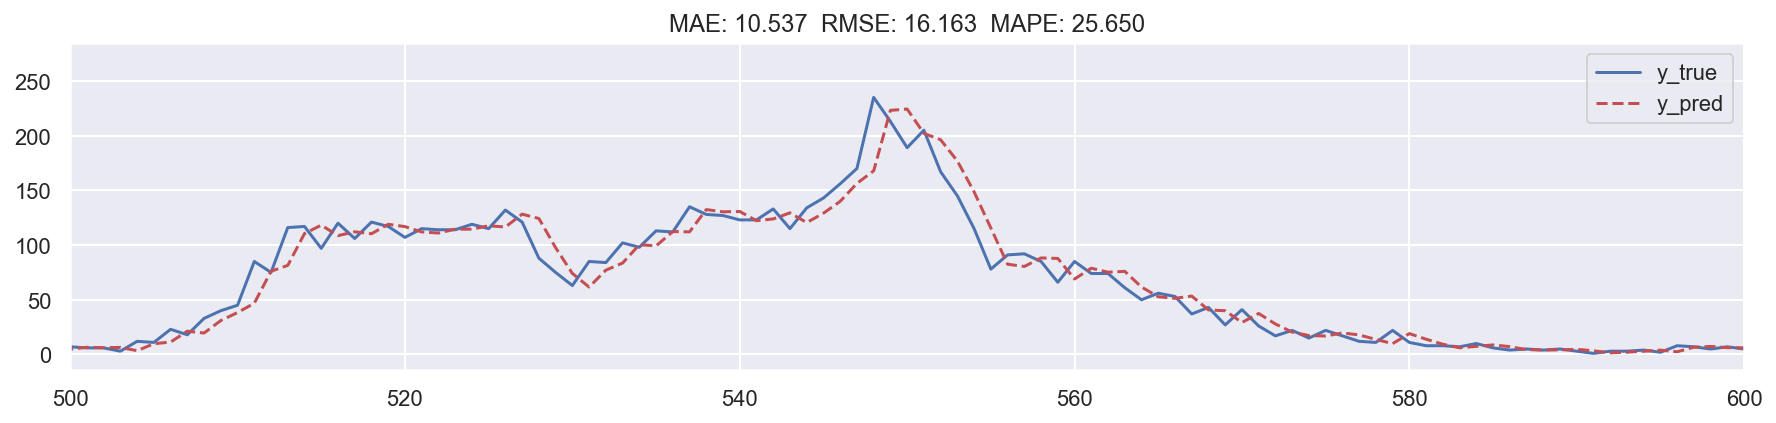

In [14]:
%matplotlib inline
test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))
plt.xlim([500,600])  # 平移现象依旧存在

In [15]:
pd.DataFrame(calc_metrics(y_true, y_pred), index=[0])

,mae,rmse,mape
0,10.53714,16.163476,25.649795
